# Passive and active colloidal chemotaxis in a microfluidic channel: mesoscopic and stochastic models

**Author:** Pierre de Buyl  
*Supplemental information to the article by L. Deprez and P. de Buyl*

This notebook reports the characterization of the diffusion coefficients for a rigid dimer
confined between plates.

The data originates from the RMPCDMD simulation program. Please read its documentation and the
published paper for meaningful use of this notebook.

The correlation functions are computed online in RMPCDMD and stored in the H5MD files. They are read here
and integrated to obtain the diffusion coefficients. A time limit on the integral is set for all integrals,
and displayed in the figures, to obtain the value of the plateau of the running integral for D.

In [7]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
from matplotlib.figure import SubplotParams
import numpy as np
from scipy.signal import fftconvolve
from scipy.optimize import leastsq, curve_fit
from scipy.integrate import simps, cumtrapz
from glob import glob

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.subplot.hspace'] = 0.25
plt.rcParams['figure.subplot.wspace'] = 0.25
plt.rcParams['figure.subplot.left'] = 0.17
plt.rcParams['axes.labelsize'] = 16

In [8]:
def expfitfunc(t, f0, tau):
    """Exponential fitting function"""
    return f0*np.exp(-t/tau)

def fitfunc(p, t):
    """Linear fitting function"""
    return p[0] + p[1]*t

def errfunc(p, t, y):
    """Error function for `fitfunc`"""
    return fitfunc(p, t) - y

def get_block_data(group, name, dim=3):
    """Return the time and correlation function for the data
    read from RMPCDMD output files."""
    block = group[name]['value'][:]
    count = group[name]['count'][:]
    block /= count.reshape((-1, 1, 1, 1))
    t_data = [np.array([0])]
    data = [block[0,:1,:,:].reshape((-1,dim))]
    dt = group[name]['time'][()]
    for i in range(block.shape[0]):
        t = dt*np.arange(block.shape[1])*block.shape[1]**i
        t_data.append(t[1:])
        data.append(block[i,1:,:,:].reshape((-1,dim)))

    return np.concatenate(t_data), np.concatenate(data)


In [11]:
# Collect simulation data

runs = glob('cceq_*.h5')

runs.sort()

msd_all = []
vacf_all = []
tvacf_all = []
pvacf_all = []
wacf_all = []

for f in runs:
    a = h5py.File(f, 'r')
    group = a['block_correlators']

    msd_t, msd_data = get_block_data(group, 'mean_square_displacement')
    msd_all.append(msd_data)

    vacf_t, vacf_data = get_block_data(group, 'velocity_autocorrelation')
    vacf_all.append(vacf_data)

    do_pvacf = 'parallel_velocity_autocorrelation' in group
    if do_pvacf:
        pvacf_t, pvacf_data = get_block_data(group, 'parallel_velocity_autocorrelation')
        pvacf_all.append(pvacf_data)

    do_tvacf = 'transverse_velocity_autocorrelation' in group
    if do_tvacf:
        tvacf_t, tvacf_data = get_block_data(group, 'transverse_velocity_autocorrelation')
        tvacf_all.append(tvacf_data)

    do_wacf = 'planar_angular_velocity_autocorrelation' in group
    if do_wacf:
        wacf_t, w_data = get_block_data(group, 'planar_angular_velocity_autocorrelation', dim=1)
        wacf_all.append(w_data.flatten())
        
    a.close()

msd_all = np.array(msd_all)
vacf_all = np.array(vacf_all)
pvacf_all = np.array(pvacf_all)
tvacf_all = np.array(tvacf_all)
wacf_all = np.array(wacf_all)

Below, we plot the mean-square displacement (MSD) of the dimer in cartesian coordinates.
There are thus three components. The z component saturates because of the confinement.
The x and y components result from a mixing of the parallel and transverse diffusion
coefficients.
The fit is for the long-time behaviour of the x-y MSD.

D_parallel + D_perp =  0.00346132554469


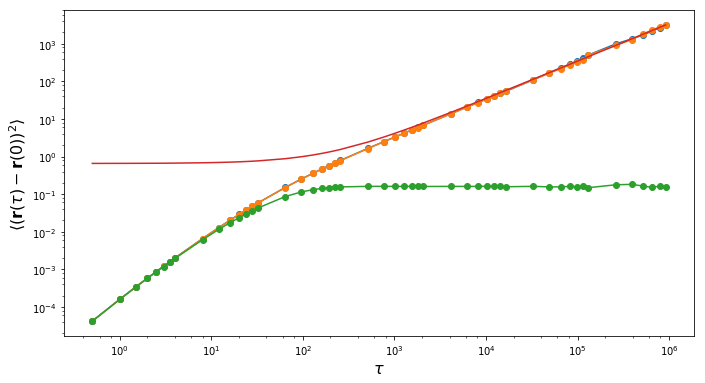

In [12]:
# Plot and fit the mean-squared displacement

plt.ylabel(r'$\langle (\mathbf{r}(\tau) - \mathbf{r}(0))^2 \rangle$')

m = msd_all.mean(axis=0)

# Plot all three components
plt.plot(msd_t, m, marker='o')

# Sum only xy components
m = m[...,:2].sum(axis=-1)

# Fit data to t>100
mask = msd_t>100
solution, ierr = leastsq(errfunc, [0, 0.1], args=(msd_t[mask], m[mask]))
intercept, D = solution

# MSD = 2 d D t = 4 D t -> The coefficient of the linear fit must be divided by 4
# as the diffusion in z is bounded by the confining plates.
D = D/4
plt.plot(msd_t, fitfunc((intercept, 2*D), msd_t))
plt.xlabel(r'$\tau$')
plt.loglog()

# Via the MSD, we can only access the sum of D_parallel and D_perp
print("D_parallel + D_perp = ", 2*D)


We use the velocity autocorrelation function (VACF) of the transverse and
parallel components of the velocity.
Integrating those functions yields the transverse and parallel diffusion
coefficients.
The integration is stopped when it reaches a plateau. This is done by setting
a limit in time, that is highlighted by reference lines in the plots.

We proceed in the same fashion for the planar angle diffusion coefficient.

Transverse D: 0.00154324462063
Parallel D: 0.00201316703627
Sum of the D's 0.0035564116569


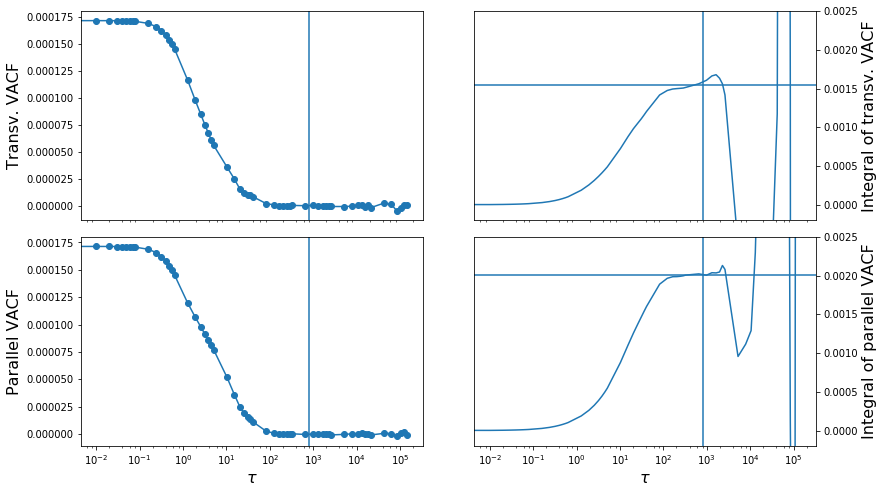

In [13]:
# Integrate the VACF

limit = 800

params = SubplotParams(hspace=0.08, wspace=0.15)
plt.figure(figsize=(14,8), subplotpars=params)

# Transverse VACF

m = tvacf_all[...,:2].sum(axis=-1).mean(axis=0)

ax1 = plt.subplot(221)

plt.plot(tvacf_t, m, marker='o')
plt.axvline(limit)
plt.xscale('log')
plt.xticks([])
plt.ylabel(r'Transv. VACF')

# Integral of transverse VACF

ax1_int = plt.subplot(222)

plt.plot(tvacf_t, cumtrapz(m, tvacf_t, initial=0))
plt.axvline(limit)
plt.xscale('log')
plt.xticks([])

idx = np.searchsorted(tvacf_t, limit)
integrated_Dt = simps(m[:idx], tvacf_t[:idx])
plt.axhline(integrated_Dt)

ax1_int.yaxis.tick_right()
ax1_int.yaxis.set_label_position('right')
plt.ylabel(r'Integral of transv. VACF')
plt.ylim(-0.0002,0.0025)

# Parallel VACF

ax2 = plt.subplot(223)

m = pvacf_all[...,:2].sum(axis=-1).mean(axis=0)
plt.plot(pvacf_t, m, marker='o')
plt.axvline(limit)
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'Parallel VACF')

# Integral of parallel VACF

ax2_int = plt.subplot(224)
plt.plot(pvacf_t, cumtrapz(m, pvacf_t, initial=0))
plt.axvline(limit)
plt.xscale('log')
plt.xlabel(r'$\tau$')

idx = np.searchsorted(pvacf_t, limit)
integrated_Dp = simps(m[:idx], pvacf_t[:idx])

plt.axhline(integrated_Dp)
plt.ylim(-0.0002,0.0025)

ax2_int.yaxis.tick_right()
ax2_int.yaxis.set_label_position('right')
plt.ylabel(r'Integral of parallel VACF')

print('Transverse D:', integrated_Dt)
print('Parallel D:', integrated_Dp)
print("Sum of the D's", integrated_Dt+integrated_Dp)


Integrated rotational diffusion coefficient 0.000141341609226


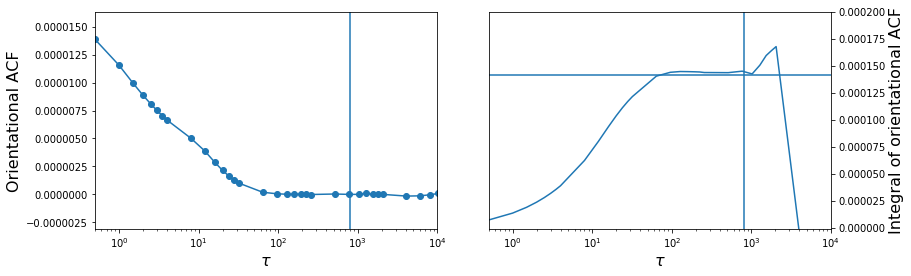

In [14]:
plt.figure(figsize=(14,4), subplotpars=params)

m = wacf_all.mean(axis=0)
s = wacf_all.std(axis=0)

ax1 = plt.subplot(121)
plt.xscale('log')

plt.plot(wacf_t, m, marker='o')
plt.axvline(limit)
plt.xlim(.5, 1e4)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Orientational ACF')

ax2 = plt.subplot(122)
plt.xscale('log')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

plt.plot(wacf_t, cumtrapz(m, wacf_t, initial=0))
plt.xlim(.5, 1e4)
plt.ylim(-1e-6, 2e-4)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Integral of orientational ACF')

limit = 800
idx = np.searchsorted(wacf_t, limit)
plt.axvline(limit)

D_integral = simps(m[:idx], wacf_t[:idx])
print('Integrated rotational diffusion coefficient', D_integral)
plt.axhline(D_integral)

plt.xlabel(r'$\tau$')
